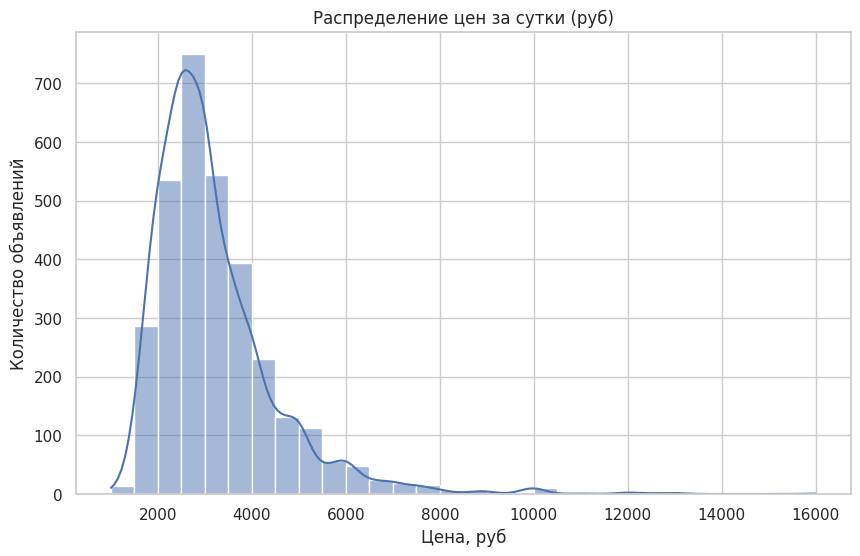

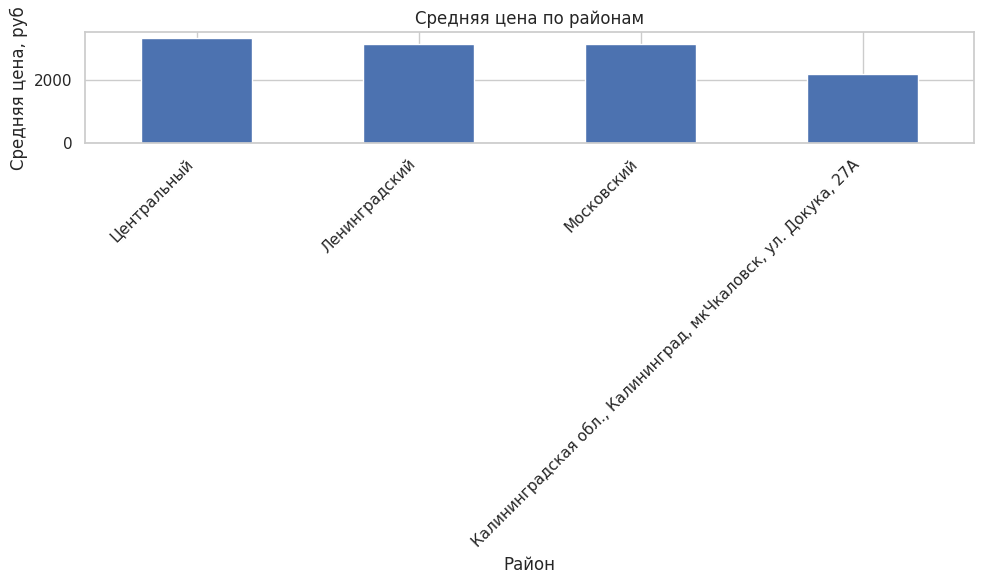

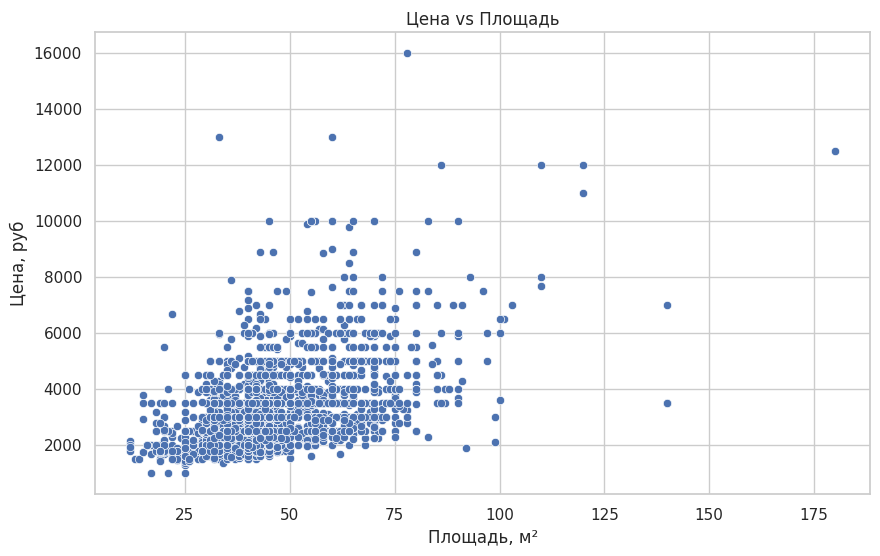

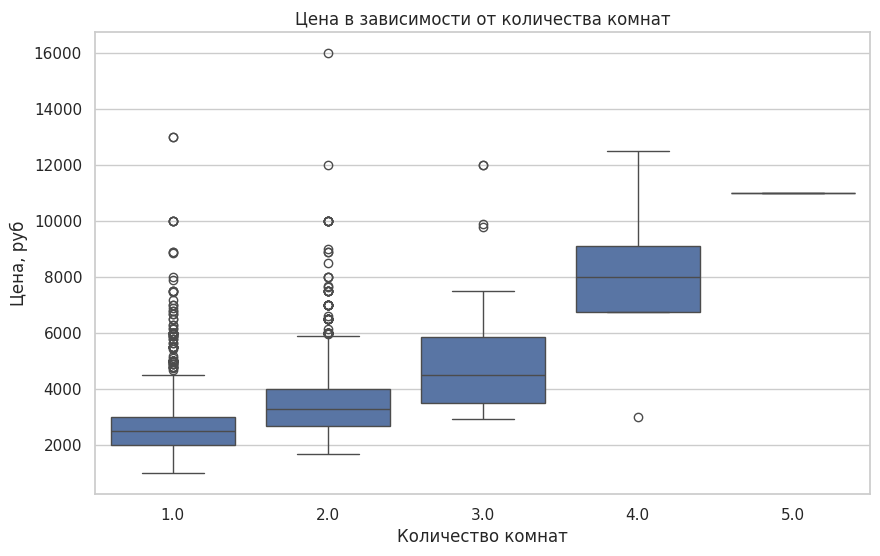


=== Основные статистики ===
Всего объявлений: 3195
Средняя цена: 3180 руб
Медианная цена: 3000 руб

Средняя цена по районам:
  Центральный: 3343 руб
  Ленинградский: 3153 руб
  Московский: 3133 руб
  Калининградская обл., Калининград, мкЧкаловск, ул. Докука, 27А: 2200 руб

Средняя площадь по количеству комнат:
rooms
1.0     38.0
2.0     54.2
3.0     72.6
4.0     95.0
5.0    120.0
Name: area, dtype: float64


In [1]:
# Установка библиотек (если нужно)
!pip install pandas matplotlib seaborn plotly

# Импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# Загрузка JSON-файла
with open('avito_full_apartments.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Преобразуем в DataFrame
df = pd.json_normalize(data)

# Очистка цены
df['price'] = df['price'].astype(str).str.replace(r'\D', '', regex=True).astype(float)

# Очистка площади
def extract_area(text):
    if pd.isna(text):
        return None
    match = re.search(r'(\d+)', str(text))
    return float(match.group(1)) if match else None

df['area'] = df['about_apartment.Общая площадь'].apply(extract_area)

# Очистка количества комнат
def extract_rooms(text):
    if pd.isna(text):
        return None
    if 'студия' in str(text).lower():
        return 1
    match = re.search(r'(\d+)', str(text))
    return int(match.group(1)) if match else None

df['rooms'] = df['about_apartment.Количество комнат'].apply(extract_rooms)

# Стандартизация районов
df['district'] = df['location.district'].str.replace(r'р-н\s*', '', regex=True).str.strip()

# Удалим явные выбросы (если нужно)
df = df[(df['price'] >= 500) & (df['price'] <= 20000)]
df = df.dropna(subset=['price', 'district'])

# === ВИЗУАЛИЗАЦИИ ===

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")

# 1. Распределение цен
plt.figure()
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Распределение цен за сутки (руб)')
plt.xlabel('Цена, руб')
plt.ylabel('Количество объявлений')
plt.show()

# 2. Средняя цена по районам
district_prices = df.groupby('district')['price'].mean().sort_values(ascending=False)
plt.figure()
district_prices.plot(kind='bar')
plt.title('Средняя цена по районам')
plt.xlabel('Район')
plt.ylabel('Средняя цена, руб')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Цена vs Площадь
plt.figure()
sns.scatterplot(data=df, x='area', y='price')
plt.title('Цена vs Площадь')
plt.xlabel('Площадь, м²')
plt.ylabel('Цена, руб')
plt.show()

# 4. Цена vs Количество комнат
plt.figure()
sns.boxplot(data=df, x='rooms', y='price')
plt.title('Цена в зависимости от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена, руб')
plt.show()

# === ПОЛЕЗНЫЕ СТАТИСТИКИ ===
print("\n=== Основные статистики ===")
print(f"Всего объявлений: {len(df)}")
print(f"Средняя цена: {df['price'].mean():.0f} руб")
print(f"Медианная цена: {df['price'].median():.0f} руб")

print("\nСредняя цена по районам:")
for district, avg_price in district_prices.items():
    print(f"  {district}: {avg_price:.0f} руб")

print("\nСредняя площадь по количеству комнат:")
print(df.groupby('rooms')['area'].mean().round(1))

In [3]:
# Установка библиотек
!pip install wordcloud



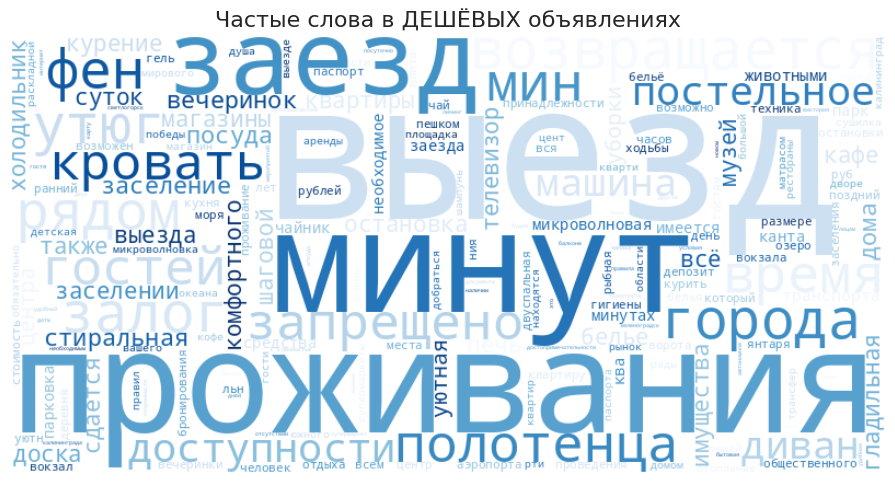

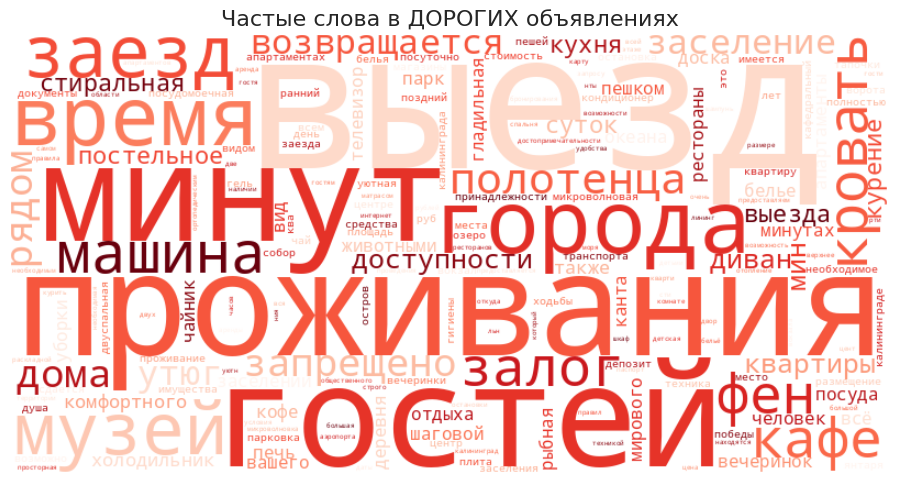


Топ-10 слов в дешёвых объявлениях:
  выезд: 520
  проживания: 512
  минут: 494
  заезд: 400
  возвращается: 398
  залог: 387
  города: 380
  утюг: 358
  рядом: 352
  фен: 346

Топ-10 слов в дорогих объявлениях:
  выезд: 501
  проживания: 497
  гостей: 479
  минут: 464
  города: 428
  время: 384
  музей: 379
  заезд: 378
  машина: 362
  кровать: 337


In [4]:
# Импорты
import pandas as pd
import re
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Загружаем стоп-слова (русские)
nltk.download('stopwords', quiet=True)
russian_stopwords = set(stopwords.words('russian'))

# Дополнительные стоп-слова, характерные для объявлений
custom_stopwords = {
    'квартира', 'квартире', 'квартирой', 'снять', 'сдаётся', 'предлагается',
    'отличное', 'хорошее', 'комнатная', 'комнаты', 'комната', 'сутки',
    'года', 'город', 'дом', 'доме', 'район', 'находится', 'расположена'
}
stopwords_set = russian_stopwords | custom_stopwords

# === Загрузка данных (повторим для уверенности) ===
with open('avito_full_apartments.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data)

# Очистка цены (если ещё не сделана)
df['price'] = df['price'].astype(str).str.replace(r'\D', '', regex=True).astype(float)

# Уберём выбросы
df = df[(df['price'] >= 500) & (df['price'] <= 20000)]

# Убедимся, что есть описание
df = df[df['description'].notna()]

# === Выделяем топ и низ по цене ===
df = df.sort_values('price')
n = max(10, len(df) // 5)  # примерно 20% снизу и сверху

cheap = df.head(n)      # самые дешёвые
expensive = df.tail(n)  # самые дорогие

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Убираем лишние символы, оставляем только буквы и пробелы
    text = re.sub(r'[^а-яА-ЯёЁ\s]', ' ', text.lower())
    # Разбиваем на слова
    words = text.split()
    # Фильтруем стоп-слова и короткие слова
    words = [w for w in words if len(w) > 2 and w not in stopwords_set]
    return " ".join(words)

# Обрабатываем описания
cheap_text = " ".join(cheap['description'].apply(clean_text))
expensive_text = " ".join(expensive['description'].apply(clean_text))

# === Облака слов ===
def plot_wordcloud(text, title, color='viridis'):
    if not text.strip():
        print(f"Нет текста для: {title}")
        return
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        stopwords=stopwords_set,
        collocations=False  # чтобы не было "евро ремонт" как одно слово
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Рисуем!
plot_wordcloud(cheap_text, "Частые слова в ДЕШЁВЫХ объявлениях", color='Blues')
plot_wordcloud(expensive_text, "Частые слова в ДОРОГИХ объявлениях", color='Reds')

# === Дополнительно: топ-10 слов в каждой группе ===
def get_top_words(text, n=10):
    words = text.split()
    return Counter(words).most_common(n)

print("\nТоп-10 слов в дешёвых объявлениях:")
for word, count in get_top_words(cheap_text):
    print(f"  {word}: {count}")

print("\nТоп-10 слов в дорогих объявлениях:")
for word, count in get_top_words(expensive_text):
    print(f"  {word}: {count}")

In [5]:
# Установка
!pip install scikit-learn pandas



Модель обучена!
MAE (средняя ошибка): 885 руб
R² (насколько объясняет): 0.11

ТОП-5 самых влиятельных факторов на цену:
               feature  importance
0                 area    0.487943
2                floor    0.206824
3         total_floors    0.163930
1                rooms    0.056908
7  district_Московский    0.033714


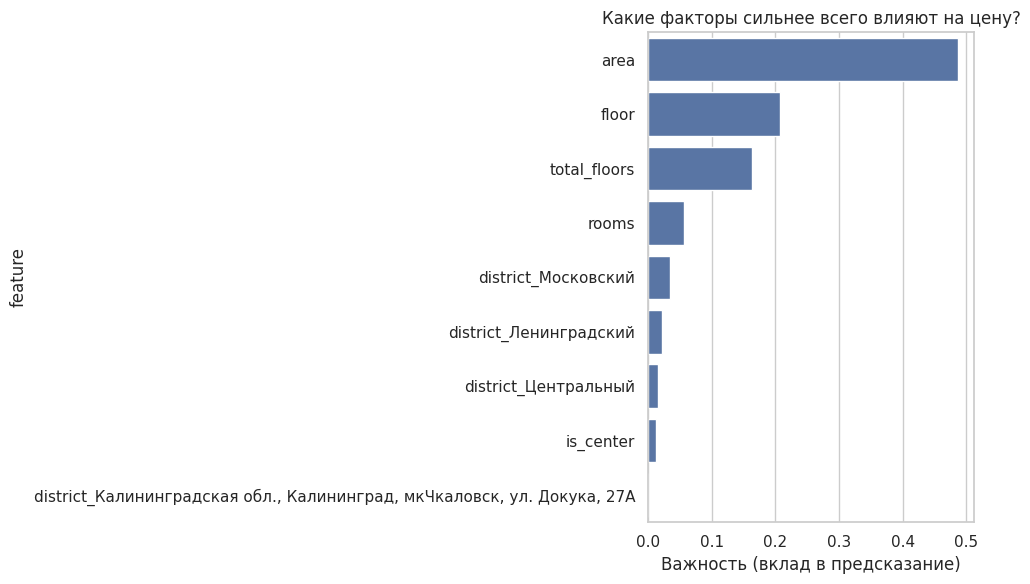


🔥 Сравнение по району:
Средняя цена в Центре: 3380 руб
Средняя цена вне Центра: 3184 руб
Разница: +196 руб за центр

📏 Влияние площади:
Каждый дополнительный м² добавляет примерно 50 руб к цене


In [7]:
# Импорты
import pandas as pd
import json
import re
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Загрузка и подготовка данных ===
with open('avito_full_apartments.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data)

# Очистка цены
df['price'] = pd.to_numeric(df['price'].astype(str).str.replace(r'\D', '', regex=True), errors='coerce')

# Площадь
df['area'] = df['about_apartment.Общая площадь'].str.extract(r'(\d+)').astype(float)

# Комнаты
df['rooms'] = df['about_apartment.Количество комнат'].str.extract(r'(\d+)').astype(float)

# Этаж и этажность
df[['floor', 'total_floors']] = df['about_apartment.Этаж'].str.split(' из ', expand=True)
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
df['total_floors'] = pd.to_numeric(df['total_floors'], errors='coerce')

# Район (чистим)
df['district'] = df['location.district'].str.replace(r'р-н\s*', '', regex=True).str.strip()

# Год постройки — попробуем из описания или about_building (в твоих данных его нет, пропустим)
# Вместо этого добавим: "центр или нет"
df['is_center'] = df['district'].str.contains('Центр', case=False, na=False).astype(int)

# Удалим выбросы и пропуски
df = df[(df['price'] >= 500) & (df['price'] <= 20000)]
df = df.dropna(subset=['price', 'area', 'rooms', 'floor', 'total_floors', 'district'])

# === One-Hot кодирование районов ===
df_encoded = pd.get_dummies(df[['price', 'area', 'rooms', 'floor', 'total_floors', 'is_center', 'district']],
                            columns=['district'], prefix='district')

# Разделение
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Обучение модели ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Оценка
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Модель обучена!")
print(f"MAE (средняя ошибка): {mae:.0f} руб")
print(f"R² (насколько объясняет): {r2:.2f}")

# === Важность признаков ===
features = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТОП-5 самых влиятельных факторов на цену:")
print(features.head(5))

# === График важности ===
plt.figure(figsize=(10, 6))
sns.barplot(data=features.head(10), x='importance', y='feature')
plt.title('Какие факторы сильнее всего влияют на цену?')
plt.xlabel('Важность (вклад в предсказание)')
plt.tight_layout()
plt.show()

# === Сравнение: центр vs не центр ===
# Найдём среднюю разницу в цене между центром и остальными
center_avg = df[df['is_center'] == 1]['price'].mean()
non_center_avg = df[df['is_center'] == 0]['price'].mean()
diff = center_avg - non_center_avg

print(f"\n🔥 Сравнение по району:")
print(f"Средняя цена в Центре: {center_avg:.0f} руб")
print(f"Средняя цена вне Центра: {non_center_avg:.0f} руб")
print(f"Разница: +{diff:.0f} руб за центр")

# === Влияние площади ===
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df['area'], df['price'])
print(f"\n📏 Влияние площади:")
print(f"Каждый дополнительный м² добавляет примерно {slope:.0f} руб к цене")

In [8]:
# Установка библиотек (если нужно)
!pip install pandas matplotlib seaborn plotly


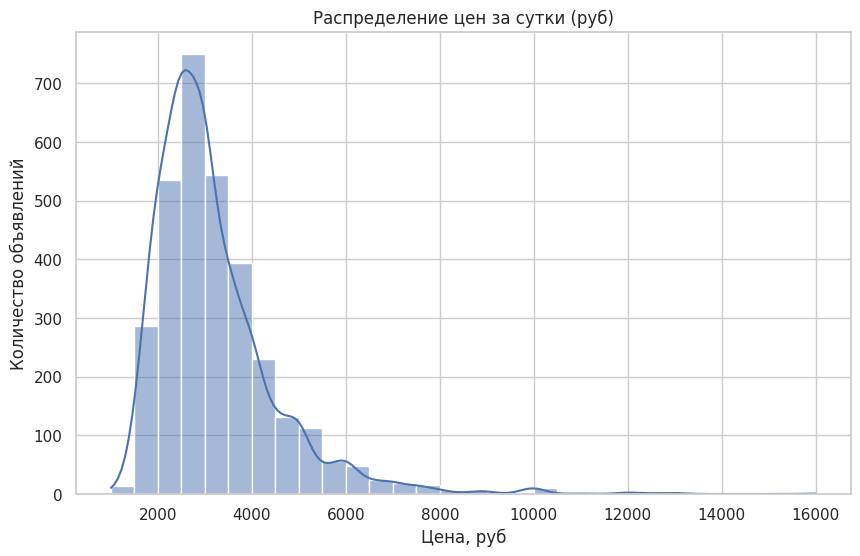

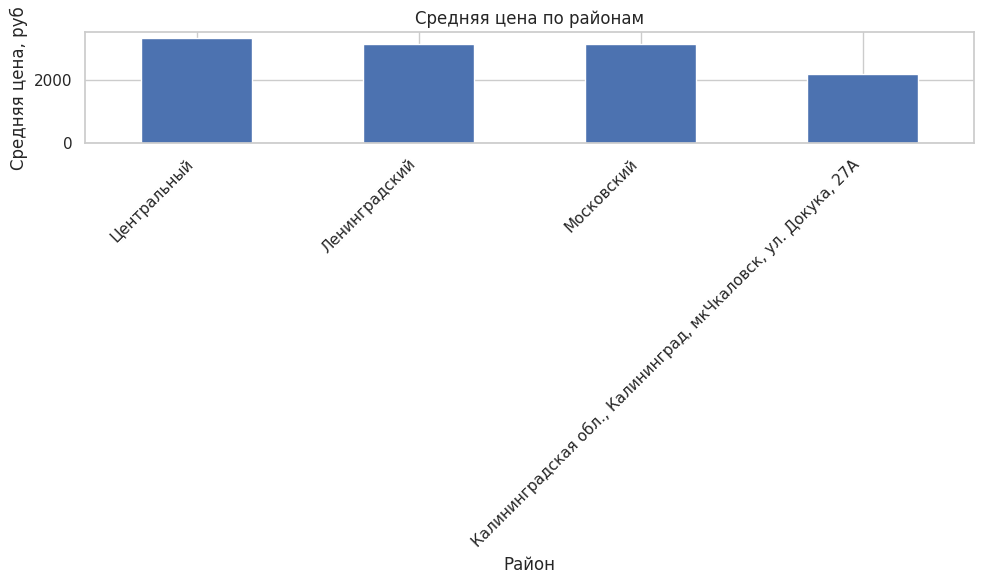

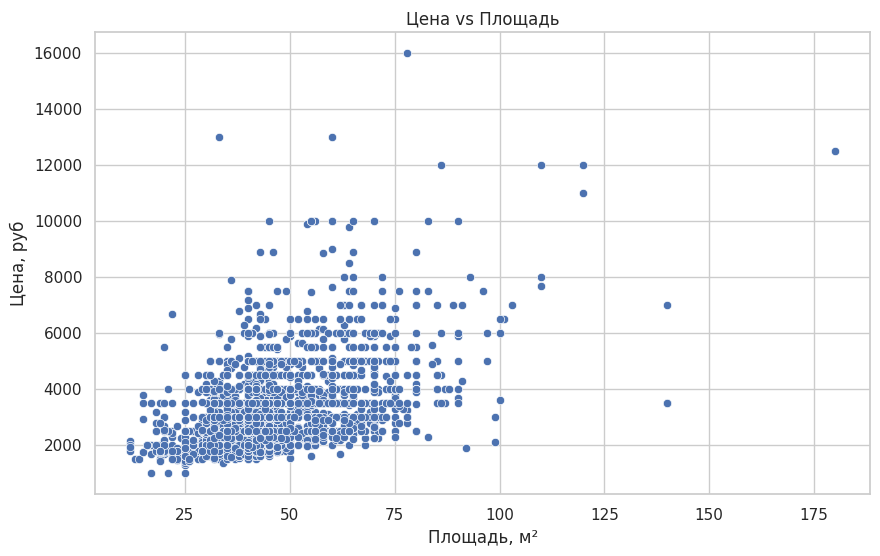

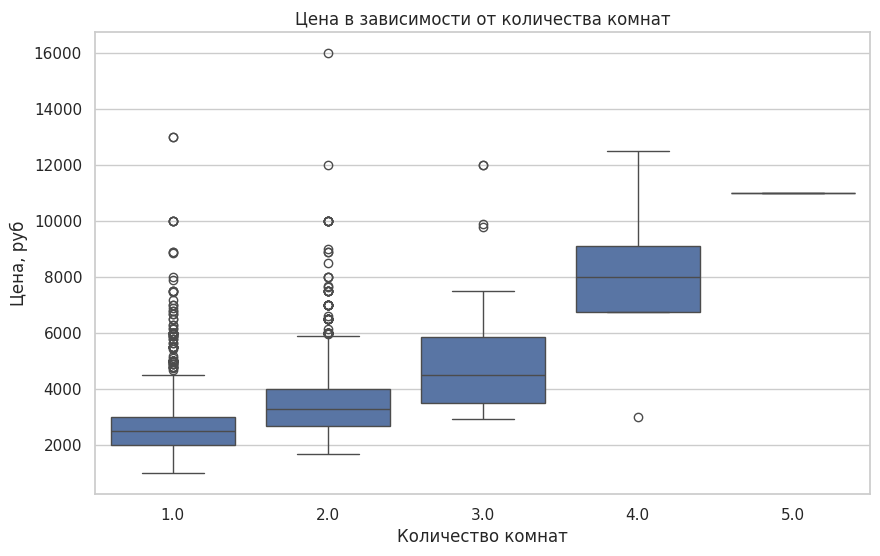


=== Основные статистики ===
Всего объявлений: 3195
Средняя цена: 3180 руб
Медианная цена: 3000 руб

Средняя цена по районам:
  Центральный: 3343 руб
  Ленинградский: 3153 руб
  Московский: 3133 руб
  Калининградская обл., Калининград, мкЧкаловск, ул. Докука, 27А: 2200 руб

Средняя площадь по количеству комнат:
rooms
1.0     38.0
2.0     54.2
3.0     72.6
4.0     95.0
5.0    120.0
Name: area, dtype: float64


In [10]:
# Импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# Загрузка JSON-файла
with open('avito_full_apartments.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Преобразуем в DataFrame
df = pd.json_normalize(data)

# Очистка цены
df['price'] = df['price'].astype(str).str.replace(r'\D', '', regex=True).astype(float)

# Очистка площади
def extract_area(text):
    if pd.isna(text):
        return None
    match = re.search(r'(\d+)', str(text))
    return float(match.group(1)) if match else None

df['area'] = df['about_apartment.Общая площадь'].apply(extract_area)

# Очистка количества комнат
def extract_rooms(text):
    if pd.isna(text):
        return None
    if 'студия' in str(text).lower():
        return 1
    match = re.search(r'(\d+)', str(text))
    return int(match.group(1)) if match else None

df['rooms'] = df['about_apartment.Количество комнат'].apply(extract_rooms)

# Стандартизация районов
df['district'] = df['location.district'].str.replace(r'р-н\s*', '', regex=True).str.strip()

# Удалим явные выбросы (если нужно)
df = df[(df['price'] >= 500) & (df['price'] <= 20000)]
df = df.dropna(subset=['price', 'district'])

# === ВИЗУАЛИЗАЦИИ ===

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")

# 1. Распределение цен
plt.figure()
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Распределение цен за сутки (руб)')
plt.xlabel('Цена, руб')
plt.ylabel('Количество объявлений')
plt.show()

# 2. Средняя цена по районам
district_prices = df.groupby('district')['price'].mean().sort_values(ascending=False)
plt.figure()
district_prices.plot(kind='bar')
plt.title('Средняя цена по районам')
plt.xlabel('Район')
plt.ylabel('Средняя цена, руб')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Цена vs Площадь
plt.figure()
sns.scatterplot(data=df, x='area', y='price')
plt.title('Цена vs Площадь')
plt.xlabel('Площадь, м²')
plt.ylabel('Цена, руб')
plt.show()

# 4. Цена vs Количество комнат
plt.figure()
sns.boxplot(data=df, x='rooms', y='price')
plt.title('Цена в зависимости от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена, руб')
plt.show()

# === ПОЛЕЗНЫЕ СТАТИСТИКИ ===
print("\n=== Основные статистики ===")
print(f"Всего объявлений: {len(df)}")
print(f"Средняя цена: {df['price'].mean():.0f} руб")
print(f"Медианная цена: {df['price'].median():.0f} руб")

print("\nСредняя цена по районам:")
for district, avg_price in district_prices.items():
    print(f"  {district}: {avg_price:.0f} руб")

print("\nСредняя площадь по количеству комнат:")
print(df.groupby('rooms')['area'].mean().round(1))